In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import os
from scipy.interpolate import interp1d
import scipy.stats as stats
import datetime
import numpy as np
import statsmodels.api as sm


def read_data(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
        # x是时间, Y-M-D H:M:S y是待参考的数据
        data_pair = data['values']
        name = data['name'] + '/' + data['unit']
        for i in data_pair:
            i['x'] = time.mktime(time.strptime(i['x'], '%Y-%m-%d %H:%M:%S'))
        
    return data_pair, name

先导入比特币币价数据，然后根据日期填充比特币奖励值，作为可使用的数据。


In [14]:
if os.path.exists('DigitCur-USD'):
    os.chdir('DigitCur-USD')

# 读取csv文件
df = pd.read_csv('BTC-USD.csv')


# 币价取开盘价
price = df['Open']
# 日期，%Y/%m/%d
date = df['Date']
date = [time.strptime(i, '%Y/%m/%d') for i in date]

# dPrice = [price[i] - price[i - 1] for i in range(1, len(price))]
bitcoin_price  = price

bitcoin_halving_date = ['2012-11-28', '2016-7-9', '2020-5-11']
bitcoin_halving_date = [time.strptime(i, '%Y-%m-%d') for i in bitcoin_halving_date]

bitcoin_miner_reward = [50 if i < bitcoin_halving_date[0] else 25 if i < bitcoin_halving_date[1] else 12.5 for i in date]

### 相关性核验

1. 直接看看减半和币价的相关性

In [15]:
best = 0
bestTime = 0
# Pearson相关系数
for delayTime in range(1, 720):
    # 认为减半的反馈具有滞后性，所以需要延迟一段时间
    p = np.corrcoef(bitcoin_miner_reward[:-delayTime], bitcoin_price[delayTime:])[0][1]
    if abs(p) > best:
        best = p
        bestTime = delayTime

print('在延迟%d天后，Pearson相关系数最大，为%f' % (bestTime, best))

#斯皮尔曼等级相关系数
def spearman_cor(x, y):
    return stats.spearmanr(x, y)[0]
def spearman_cor_p(x, y):
    return stats.spearmanr(x, y)[1]

tmp_x = bitcoin_miner_reward[:-bestTime]
tmp_y = bitcoin_price[bestTime:].to_list()

print(tmp_x, '\n', tmp_y)

spearman_correlation = spearman_cor(tmp_x, tmp_y)
spearman_correlation_p = spearman_cor_p(tmp_x, tmp_y)
print('斯皮尔曼等级相关系数为%f, p值为%f' % (spearman_correlation, spearman_correlation_p))


# 添加截距项
tmp_x = sm.add_constant(tmp_x)

# 拟合线性回归模型
model = sm.OLS(tmp_y, tmp_x).fit()
print(model.summary())



在延迟719天后，Pearson相关系数最大，为-0.475145
[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2

**结论：直接研究减半和币价的相关性不是很强，宏观上看是约延迟一年半左右。**

考虑到还有很多其他因素影响，这个数值仅能作为参考。



2.  比特币币价-挖矿奖励-比特率的相关性

挖矿奖励的原文是Total value of coinbase block rewards and transaction fees paid to miners，即挖矿奖励的总价值，包括区块奖励和交易费用。这二者都能一定程度上反应比特币交易的活跃程度。

哈希率是衡量区块链网络安全性和矿工活动水平的重要指标，指整个网络中所有矿工每秒钟产生的计算次数，通常以哈希/秒为单位。（就是算力）


In [6]:
data, name = read_data('miners-revenue.json')

best = 0
bestTime = 0

data_x = [i['x'] for i in data]
data_y = [i['y'] for i in data]

f = interp1d(data_x, data_y, kind='cubic')
new_y = f([time.mktime(i) for i in date])
# normalize
nor_y = (new_y - np.mean(new_y)) / np.std(new_y)

nor_btc_reward = (bitcoin_miner_reward - np.mean(bitcoin_miner_reward)) / np.std(bitcoin_miner_reward)


# Pearson相关系数
for delayTime in range(1, 720):
    # 认为减半的反馈具有滞后性，所以需要延迟一段时间
    p = np.corrcoef(nor_btc_reward[:-delayTime], nor_y[delayTime:])[0][1]
    if abs(p) > best:
        best = abs(p)
        bestTime = delayTime
        

print('在延迟%d天后，Pearson相关系数最大，为%f' % (bestTime, best))


在延迟400天后，Pearson相关系数最大，为0.575354


In [6]:
data, name = read_data('hash-rate.json')
data_x = [i['x'] for i in data]
data_y = [i['y'] for i in data]

f = interp1d(data_x, data_y, kind='cubic')
new_y = f([time.mktime(i) for i in date])

best = 0
bestTime = 0
for delayTime in range(1, 720):
    # 认为减半的反馈具有滞后性，所以需要延迟一段时间
    p = np.corrcoef(bitcoin_miner_reward[:-delayTime], new_y[delayTime:])[0][1]
    if abs(p) > best:
        best = abs(p)
        bestTime = delayTime

print('在延迟%d天后，Pearson相关系数最大，为%f' % (bestTime, best))


在延迟719天后，Pearson相关系数最大，为0.584497


3. 块均交易数的图表

较高的块均交易数通常表示比特币网络上正在发生大量交易活动。这可能是由于用户之间的资金转移、
交易所活动、智能合约执行等。在高交易活跃度的情况下，交易确认可能需要更长的时间，因为区块大小和区块生成时间都是有限制的。


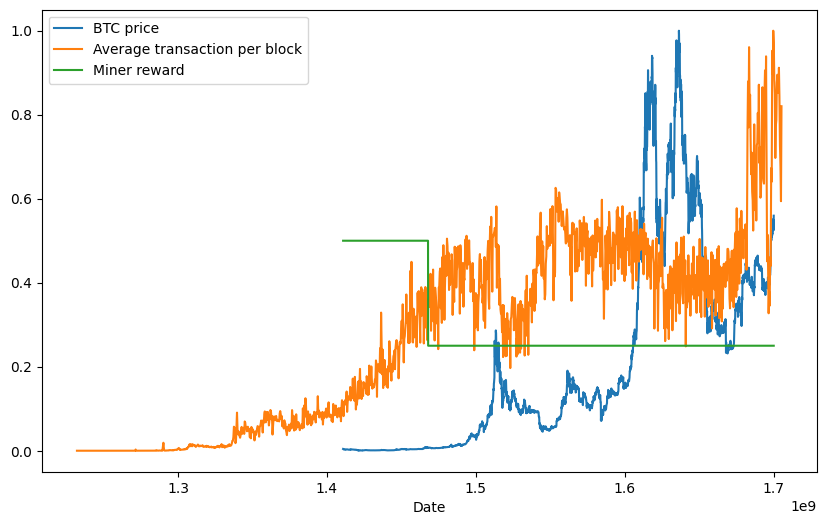

In [7]:

data, name = read_data('ave-trans-per-block.json')

plt.figure(figsize=(10, 6))

btcPrice_max = max(bitcoin_price)
btcPrice_min = min(bitcoin_price)
normalized_bitcoin_price = [(i - btcPrice_min) / (btcPrice_max - btcPrice_min) for i in bitcoin_price] # 归一化

data_time = [i['x'] for i in data]
data_value = [i['y'] for i in data]
data_value_max = max(data_value)
data_value_min = min(data_value)
data_value = [(i - data_value_min) / (data_value_max - data_value_min) for i in data_value] # 归一化



plt.plot([time.mktime(i) for i in date], normalized_bitcoin_price, label='BTC price')
plt.plot(data_time, data_value, label='Average transaction per block')
plt.plot([time.mktime(i) for i in date], [i/50 for i in bitcoin_miner_reward], label='Miner reward')

plt.xlabel('Date')

plt.legend()
plt.show()


图表显示，在整体趋势上存在不算显著的、略微延迟的负相关。

### 每日确认的交易量图标


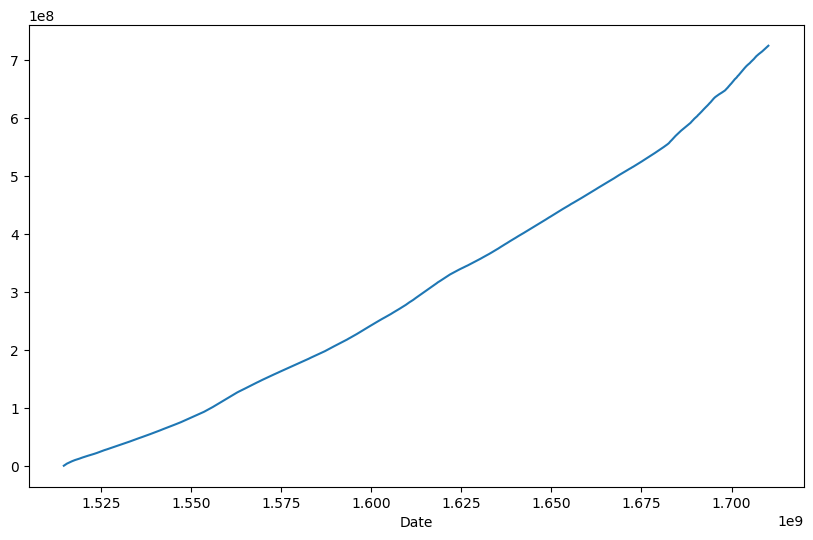

In [8]:
data, name = read_data('confirmed-transactions-per-day.json')
                       
plt.figure(figsize=(10, 6))

data_time = [i['x'] for i in data]
data_value = [i['y'] for i in data]
total_value = []

sum = 0
for i in data_value:
    total_value.append(sum + i)
    sum += i
#     
# print(total_value)
#     
plt.plot(data_time, total_value, label='Confirmed transactions')

plt.xlabel('Date')
plt.show()


图表显示，交易总量波动不显著，认为减半和使用频率的相关性不大。